In [21]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Dataset Loading and Preprocessing

In [22]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [23]:
mnist = keras.datasets.mnist
(x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, x_train.shape[1], x_train.shape[2], 1])
x_test = np.reshape(x_test, [-1, x_test.shape[1], x_test.shape[2], 1])
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# 노이즈 추가
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

# 0. ~ 1. 사이로 제한
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Modeling

In [24]:
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape
from keras import backend as K

In [25]:
input_shape = x_train.shape[1:]
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64]

In [26]:
def encoder(inputs, layer_filters, latent_dim):
    x = inputs
    for filters in layer_filters:
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   activation='relu',
                   strides=2,
                   padding='same'
                  )(x)
    shape = K.int_shape(x) 
    x = Flatten()(x)
    latent = Dense(latent_dim, name='latent_vector')(x)
    
    encoder = keras.Model(inputs=inputs, outputs=latent, name='encoder')
    return encoder, shape

In [27]:
inputs = keras.Input(shape=input_shape, name='encoder_input')
encoder, shape = encoder(inputs, layer_filters, latent_dim)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69008 (269.56 KB)
Trainable params: 69008 (269.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
def decoder(shape, layer_filters, latent_dim, kernel_size):
    latent_inputs = keras.Input(shape=(latent_dim), name='decoder_input')
    x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs) # Flatten
    x = Reshape((shape[1], shape[2], shape[3]))(x)
    
    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            activation='relu',
                            strides=2,
                            padding='same'
                           )(x)
    outputs = Conv2DTranspose(filters=1,
                              kernel_size=kernel_size,
                              activation='sigmoid',
                              padding='same',
                              name='decoder_output'
                             )(x)

    decoder = keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')
    return decoder

In [29]:
decoder = decoder(shape, layer_filters, latent_dim, kernel_size)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense_2 (Dense)             (None, 3136)              53312     
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289 

In [30]:
autoencoder = keras.Model(inputs, decoder(encoder(inputs)), name='autoencoder')

In [31]:
autoencoder.compile(loss='mse',
                    optimizer='adam'
                   )
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178001 (695.32 KB)
Trainable params: 178001 (695.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


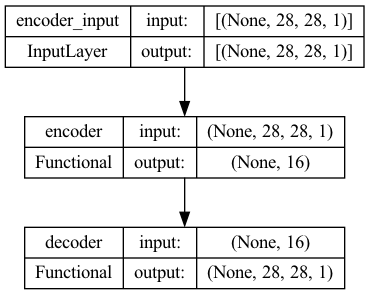

In [32]:
save_dir = os.path.join(os.getcwd(), 'MNIST_DAE')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
keras.utils.plot_model(autoencoder, to_file=save_dir+'/dae.png', show_shapes=True)

In [33]:
autoencoder.fit(x_train_noisy, x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size
               )

Epoch 1/10
   7/1875 [..............................] - ETA: 17s - loss: 0.2236 

2023-06-24 18:09:43.743223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1873/1875 [============================>.] - ETA: 0s - loss: 0.0370

2023-06-24 18:09:58.237283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 16s 8ms/step - loss: 0.0369 - val_loss: 0.0204
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0192 - val_loss: 0.0180
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0176 - val_loss: 0.0171
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0169 - val_loss: 0.0165
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0158 - val_loss: 0.0160
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0155 - val_loss: 0.0158
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 10/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0152

## Test

In [34]:
x_decoded = autoencoder.predict(x_test_noisy)

 44/313 [===>..........................] - ETA: 0s

2023-06-24 18:12:17.311654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step


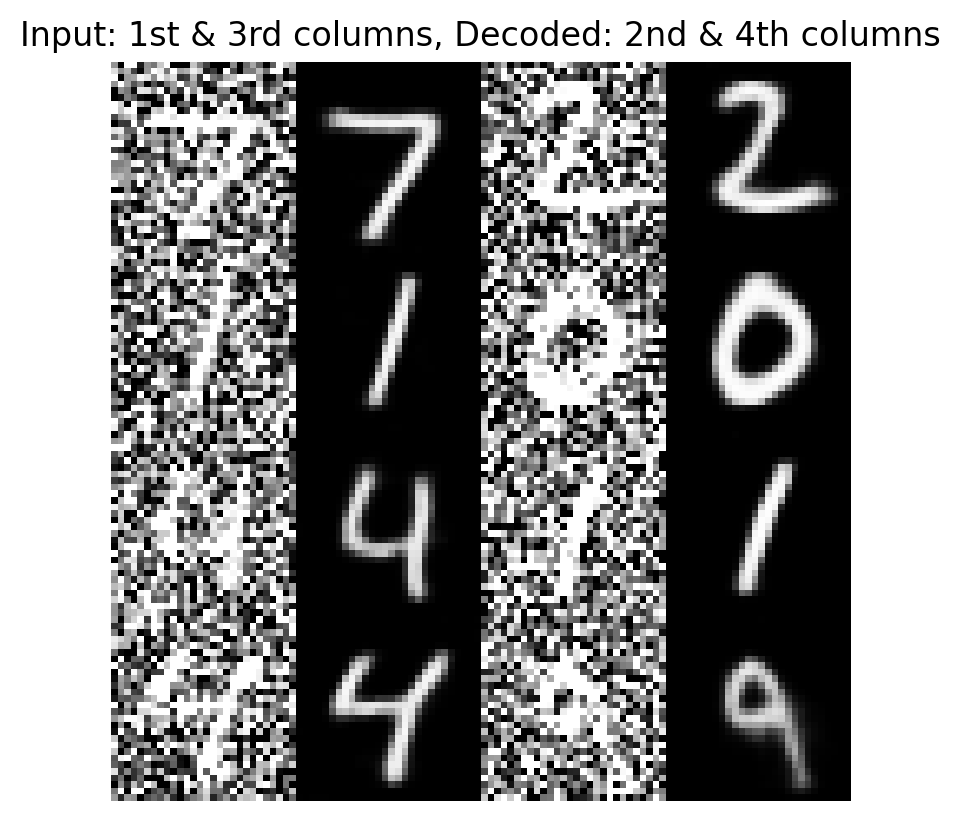

In [36]:
filepath2 = os.path.join(save_dir, 'noised_and_denoised.png')

imgs = np.concatenate([x_test_noisy[:8], x_decoded[:8]], axis=1)
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Input: 1st & 3rd columns, Decoded: 2nd & 4th columns')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig(filepath2)
plt.show()